# Question 1: Bayes Classifier
Implement Bayes classifier for three datasets under four covariance assumptions.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

# Utility: load class data from text file
def load_class_data(path, label):
    data = np.loadtxt(path)  # two columns
    labels = np.full((data.shape[0],), label)
    return data, labels

# Utility: split each class into train and test sets (70/30)
def split_data(X, y, test_size=0.3, random_state=42):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

# Estimate Gaussian parameters for each class
def estimate_parameters(X, y):
    classes = np.unique(y)
    params = {}
    for c in classes:
        Xc = X[y==c]
        mu = Xc.mean(axis=0)
        cov = np.cov(Xc, rowvar=False)
        params[c] = {'mu': mu, 'cov': cov}
    return params

# Gaussian density
def gaussian_pdf(x, mu, cov):
    d = len(mu)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm = 1 / np.sqrt((2*np.pi)**d * det)
    diff = x - mu
    return norm * np.exp(-0.5 * diff @ inv @ diff.T)

# Bayes classifier general function
def predict_bayes(X, params, priors, cov_type='class_full', sigma2=None, shared_cov=None):
    # cov_type: 'spherical', 'shared_full', 'class_diag', 'class_full'
    classes = list(params.keys())
    y_pred = []
    for x in X:
        post = []
        for c in classes:
            mu = params[c]['mu']
            if cov_type=='spherical': cov = sigma2 * np.eye(len(mu))
            elif cov_type=='shared_full': cov = shared_cov
            elif cov_type=='class_diag': cov = np.diag(np.diag(params[c]['cov']))
            else: cov = params[c]['cov']
            post.append(priors[c] * gaussian_pdf(x, mu, cov))
        y_pred.append(classes[np.argmax(post)])
    return np.array(y_pred)

# Decision surface plotting helper
def plot_decision_surface(X, y, params, priors, cov_type, sigma2, shared_cov):
    # create mesh grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Determine arguments for predict_bayes based on cov_type
    predict_kwargs = {'sigma2': sigma2, 'shared_cov': shared_cov}
    Z = predict_bayes(grid, params, priors, cov_type=cov_type, **predict_kwargs)

    Z = Z.reshape(xx.shape)

    cmap = ListedColormap(['#FFAAAA','#AAFFAA','#AAAAFF'])
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

    # plot training points
    for cls in np.unique(y):
        pts = X[y==cls]
        plt.scatter(pts[:,0], pts[:,1], label=f'Class {int(cls)}', s=20, alpha=0.7)
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    title_str = cov_type.replace('_', ' ').title()
    plt.title(f'Decision Boundary: {title_str} Covariance')
    plt.show()

# Common function to evaluate and plot Bayes classifier for a dataset
def run_dataset(name, X, y):
    # split data
    X_train, X_test, y_train, y_test = split_data(X, y)
    # estimate parameters
    params = estimate_parameters(X_train, y_train)
    # compute class priors
    priors = {c: np.mean(y_train==c) for c in params}
    # spherical variance
    sigmas = [np.mean(np.diag(params[c]['cov'])) for c in params]
    sigma2 = np.mean(sigmas)
    # shared full covariance
    shared_cov = sum(params[c]['cov'] for c in params) / len(params)
    types = [
        ('spherical', {'sigma2': sigma2}),
        ('shared_full', {'shared_cov': shared_cov}),
        ('class_diag', {}),
        ('class_full', {})
    ]

    equals_sep = '=' * 10  # Define the separator string
    print(f'\n{equals_sep} {name} {equals_sep}') # Use the variable in the f-string
    classes = sorted(params.keys())

    for cov_type, kwargs in types:
        y_pred = predict_bayes(X_test, params, priors, cov_type=cov_type, **kwargs)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average=None, labels=classes, zero_division=0)
        rec = recall_score(y_test, y_pred, average=None, labels=classes, zero_division=0)
        f1 = f1_score(y_test, y_pred, average=None, labels=classes, zero_division=0)
        cm = confusion_matrix(y_test, y_pred, labels=classes)

        # Calculate title string separately
        title_str = cov_type.replace('_', ' ').title()
        print(f'\n--- {title_str} Covariance --- ')
        print(f'Accuracy:         {acc:.4f}')

        # Create a DataFrame for per-class metrics
        metrics_df = pd.DataFrame({
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        }, index=[f'Class {int(c)}' for c in classes])
        print("\nPer-Class Metrics:")
        print(metrics_df.to_string(float_format='{:.4f}'))

        print(f'\nMean Precision:   {prec.mean():.4f}')
        print(f'Mean Recall:      {rec.mean():.4f}')
        print(f'Mean F1-Score:    {f1.mean():.4f}')

        # Create a DataFrame for the confusion matrix
        cm_df = pd.DataFrame(cm, index=[f'True {int(c)}' for c in classes], columns=[f'Pred {int(c)}' for c in classes])
        print('\nConfusion Matrix:')
        print(cm_df)
        print('-'*30)

        # Plot decision boundary on training data
        plot_decision_surface(X_train, y_train, params, priors, cov_type, sigma2, shared_cov)


========== Linearly separable ==========

--- Spherical Covariance --- 
Accuracy:         1.0000

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   1.0000
Mean Recall:      1.0000
Mean F1-Score:    1.0000

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     150       0       0
True 1       0     150       0
True 2       0       0     150
------------------------------


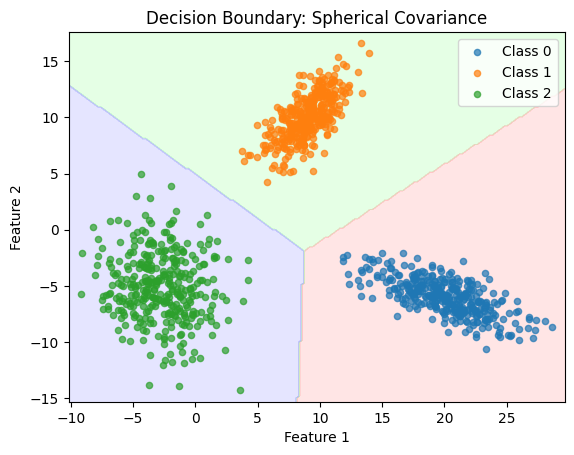


--- Shared Full Covariance --- 
Accuracy:         1.0000

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   1.0000
Mean Recall:      1.0000
Mean F1-Score:    1.0000

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     150       0       0
True 1       0     150       0
True 2       0       0     150
------------------------------


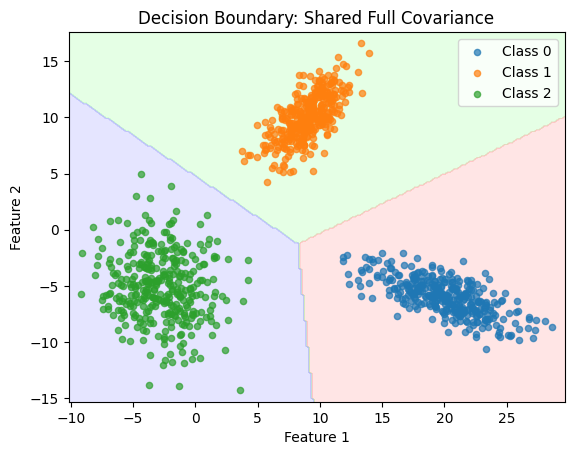


--- Class Diag Covariance --- 
Accuracy:         1.0000

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   1.0000
Mean Recall:      1.0000
Mean F1-Score:    1.0000

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     150       0       0
True 1       0     150       0
True 2       0       0     150
------------------------------


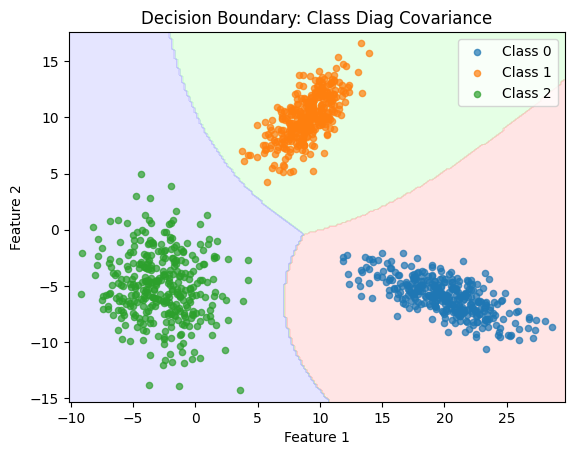


--- Class Full Covariance --- 
Accuracy:         1.0000

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   1.0000
Mean Recall:      1.0000
Mean F1-Score:    1.0000

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     150       0       0
True 1       0     150       0
True 2       0       0     150
------------------------------


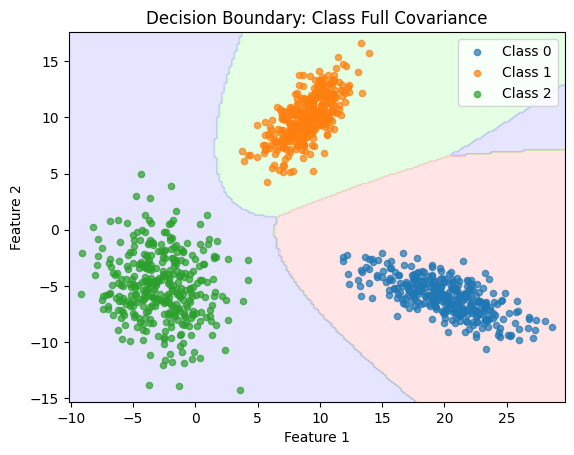

In [22]:
# Dataset 1: Linearly separable classes
# Corrected file paths to be relative to the notebook location
files = ['Datasets Assignment 3/LS_Group12/Class1.txt', 'Datasets Assignment 3/LS_Group12/Class2.txt', 'Datasets Assignment 3/LS_Group12/Class3.txt']
X1 = np.vstack([load_class_data(f, i)[0] for i,f in enumerate(files)])
y1 = np.concatenate([load_class_data(f, i)[1] for i,f in enumerate(files)])
run_dataset('Linearly separable', X1, y1)


========== Nonlinearly separable ==========

--- Spherical Covariance --- 
Accuracy:         0.8378

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.8377
Mean Recall:      0.8378
Mean F1-Score:    0.8315

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     138      12       0
True 1      24      96      30
True 2       0       7     143
------------------------------


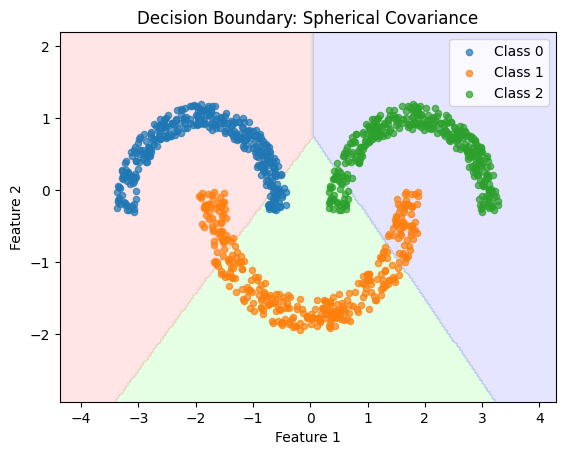


--- Shared Full Covariance --- 
Accuracy:         0.9200

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.9210
Mean Recall:      0.9200
Mean F1-Score:    0.9187

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     145       5       0
True 1      10     123      17
True 2       0       4     146
------------------------------


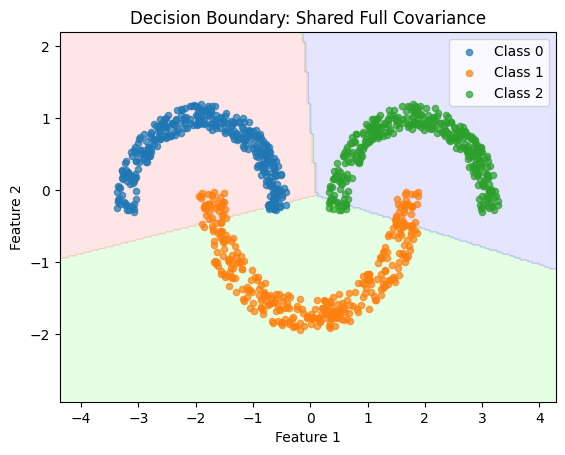


--- Class Diag Covariance --- 
Accuracy:         0.9378

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.9376
Mean Recall:      0.9378
Mean F1-Score:    0.9373

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     144       6       0
True 1       9     132       9
True 2       0       4     146
------------------------------


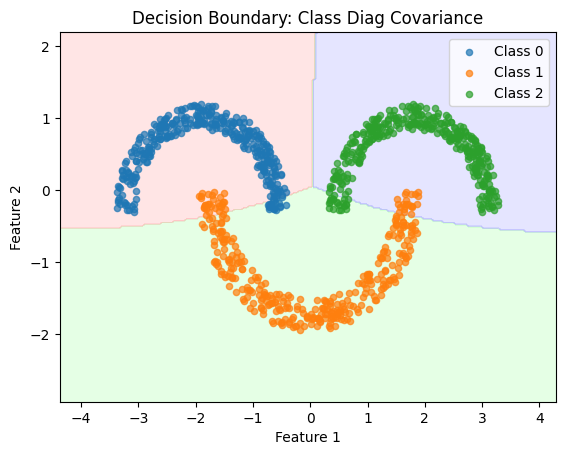


--- Class Full Covariance --- 
Accuracy:         0.9378

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.9376
Mean Recall:      0.9378
Mean F1-Score:    0.9373

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     144       6       0
True 1       9     132       9
True 2       0       4     146
------------------------------


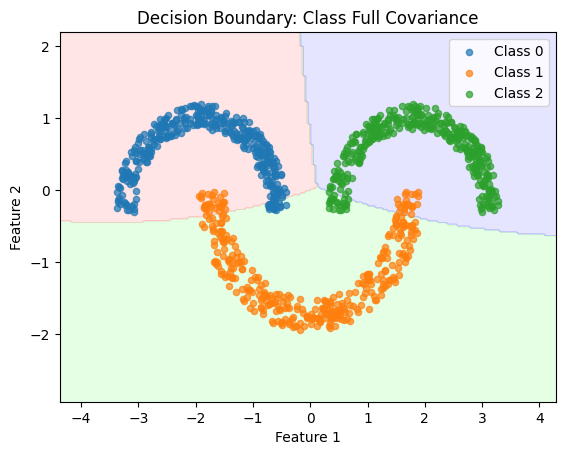

In [23]:
# Dataset 2: Nonlinearly separable classes
import re  # for parsing counts
def load_nls_data(path):
    with open(path) as f:
        first_line = f.readline()
        # extract counts before 'examples' in the header
        counts = list(map(int, re.findall(r'(\d+)(?=\s+examples)', first_line)))
    data = np.loadtxt(path, skiprows=1)
    X = data[:, :2]
    # build labels according to parsed counts
    y = np.concatenate([np.full(cnt, i) for i, cnt in enumerate(counts)])
    return X, y
# load and run
# Corrected file path
X2, y2 = load_nls_data('Datasets Assignment 3/NLS_Group12.txt')
run_dataset('Nonlinearly separable', X2, y2)


========== Vowel data ==========

--- Spherical Covariance --- 
Accuracy:         0.8945

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.8985
Mean Recall:      0.8969
Mean F1-Score:    0.8971

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     678       3       6
True 1       0     615     132
True 2       0      88     648
------------------------------


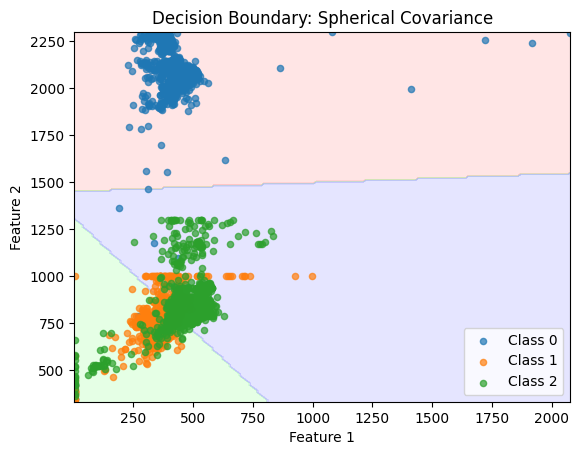


--- Shared Full Covariance --- 
Accuracy:         0.9207

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.9233
Mean Recall:      0.9223
Mean F1-Score:    0.9227

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     678       5       4
True 1       0     673      74
True 2       0      89     647
------------------------------


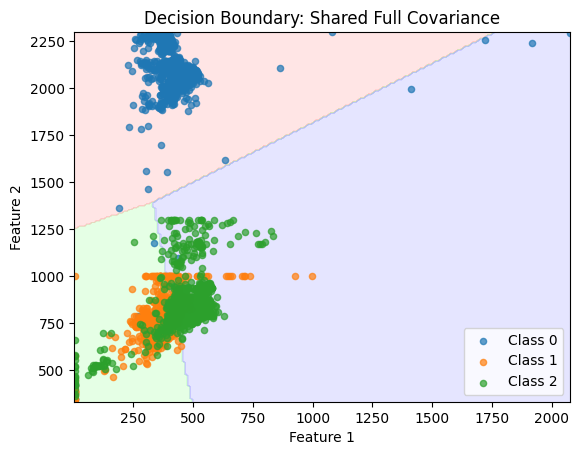


--- Class Diag Covariance --- 
Accuracy:         0.9065

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.9092
Mean Recall:      0.9084
Mean F1-Score:    0.9088

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     679       3       5
True 1       0     653      94
True 2       0     101     635
------------------------------


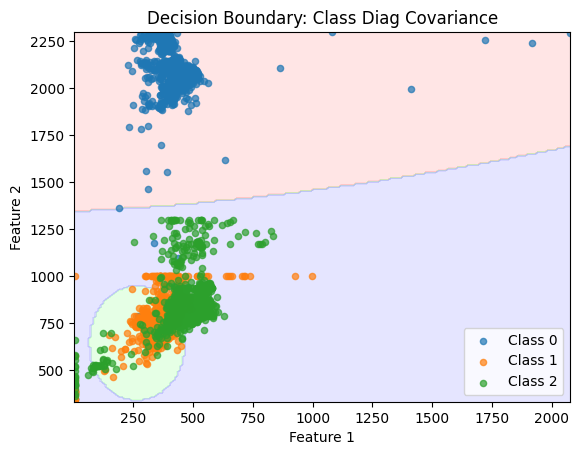


--- Class Full Covariance --- 
Accuracy:         0.9037

Per-Class Metrics:
         Precision  Recall  F1-Score
Class 0     {:.4f}  {:.4f}    {:.4f}
Class 1     {:.4f}  {:.4f}    {:.4f}
Class 2     {:.4f}  {:.4f}    {:.4f}

Mean Precision:   0.9069
Mean Recall:      0.9056
Mean F1-Score:    0.9060

Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0     679       3       5
True 1       0     663      84
True 2       1     116     619
------------------------------


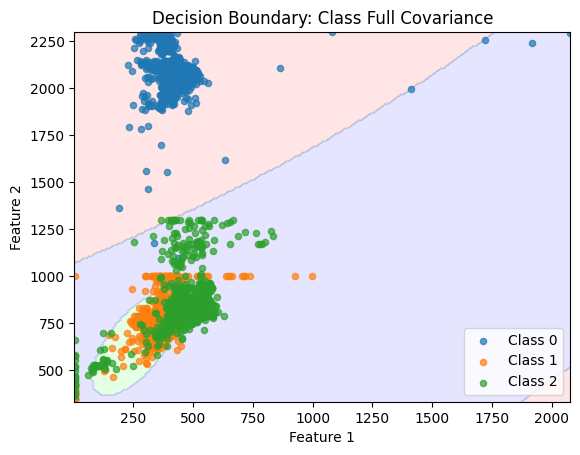

In [24]:
# Dataset 3: Real-world vowel data
# Corrected file paths
files = ['Datasets Assignment 3/rd_group12/class1.txt', 'Datasets Assignment 3/rd_group12/class2.txt', 'Datasets Assignment 3/rd_group12/class3.txt']
X3 = np.vstack([load_class_data(f, i)[0] for i,f in enumerate(files)])
y3 = np.concatenate([load_class_data(f, i)[1] for i,f in enumerate(files)])
run_dataset('Vowel data', X3, y3)